# ARIM情報活用講座：
# 論文：Prediction of organic compound aqueous solubility using machine learning  
### Part-1 (Mordred分子記述子)

Tayyebi, A., Alshami, A.S., Rabiei, Z. et al. Prediction of organic compound aqueous solubility using machine learning: a comparison study of descriptor-based and fingerprints-based models. J Cheminform 15, 99 (2023).   
https://doi.org/10.1186/s13321-023-00752-6



### 要約
化合物の溶解度の予測精度にかかる説明変数の依存性を分子記述子（Mordred）とMorganフィンガープリント(ECFP4)を適用した機械学習（ML）モデルで予測精度を検証。生成されたMLモデルを解釈するために、SHAP（Shapley Additive exPlanations）と熱力学的解析を使用し、水溶性測定に最も効果的な特徴量を調査している。

フィンガープリント法は、低い誤差、分子レベルの相互作用を調査する能力、および熱力学的量との互換性があり、他の利用可能な計算ツールと比較して優れていた。
一方、物理化学記述子モデル（Mordred）は、与えられたテストセットに対して、より優れた予測精度を達成する点でフィンガープリント・モデルを上回っていた。

### 背景　
これまでの研究から、機械学習による水溶性の予測は可能であることが明らかになっている。しかし、この分野を初めて探究する研究者は、アルゴリズムの複雑さであるがゆえに、モデル構築や評価の理解の難しさに直面します。

さらに、現在の研究において懸念されているのは、相関関係の妥当性です。特に、機械学習の性能における化学的表現の影響とその役割については、まだ十分に研究されていないと言えます。この研究では、記述子ベース（Mordred）とフィンガープリント法（ECFP4）を比較し、データの事前処理と事後処理が機械学習の精度に及ぼす影響を調査しました。

### データセット
溶解度のデータセットは、3つの文献ベースの大規模データベースから有機化合物の水溶解度を収集したものを用いています。  
1. Vermeire's (11804 datapoints) 
2. Boobier's (901 datapoints) 
3. Delaney's (1145 datapoints) 

これらから、1つの分子に対して複数の溶解度測定値からなる場合やノイズの多いデータの場合は除外され、合計8,438化合物のデータエントリとしています。（Additional file 1）。

### Model

分子記述子法とフィンガープリント法を使用して予測精度の検証比較をしています。

**分子記述子法**: 物理化学的特性や分子の構造に関連する特徴をフラグメントとして定義し、これを利用して予測モデルを構築しています。通常、記述子ベースのモデルは既知の特徴のセットに依存しますが、本論文では、Mordredパッケージを使用して、1,613個の2次元（2D）記述子を生成し、予測速度を向上させました。なお、3D記述子の再現性の問題を回避するため、3D記述子は採用していません。

**フィンガープリント法**: 物質の特性を分子の特徴を通して包括し、より動的な表現を提供します。分子フィンガープリントには様々なタイプがあり、分子フラグメントをバイナリ文字列に変換する方法によって決定されます。分子内の結合は個別に2進数（ビット）の列として定義され、これにより分子特性に関する情報がより多く保存されます。そのため、長いビット列を持つフィンガープリントは、類似性検索においてより信頼性が高いです。

この研究では、Morganアルゴリズムをフィンガープリント法として使用。モーガンフィンガープリントは拡張接続性フィンガープリント（ECFP）としても知られ、最も一般的な円形フィンガープリントです。これらの円形フィンガープリントは、中心原子から与えられた「半径」または「直径」までの各原子の「円形」環境を考慮することにより生成されます。本研究では、直径4の円形フィンガープリントであるECFP4を使用しました。

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!pip install shap
!pip install mordred
!git clone https://github.com/ARIM-Training/Training_python_12.git
%cd Training_python_12

## 1.データの読み込み
### 汎用ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# rdkit
from rdkit import Chem

# 警告を無視
from warnings import filterwarnings
filterwarnings('ignore')

### データセットファイルの読み込み
サンプルデータのファイルは「new222new.csv」で、これは「data」フォルダに保存されています。このファイルをpandasの`read_csv()`メソッドを使用して読み込み、変数`sol`にデータフレーム（DataFrame）型として格納します。

変数`sol`は8,438のサンプルから成り、SMILESと溶解度実験値の2つのカラムを持つデータ行列です。これによって、ファイル内のデータが正常に読み込まれたことが確認されます。

In [5]:
sol = pd.read_csv('data/new222new.csv')
sol

,SMILES,measured log(solubility:mol/L)
0,OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O,0.79
1,O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...,0.79
2,OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...,0.79
3,CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2,0.65
4,CN1CC2CC(C1)C1=CC=CC(=O)N1C2,0.65
...,...,...
8433,O=[N+]([O-])C,0.26
8434,OC,1.57
8435,S=C(N)N,0.32
8436,O=C(NO)N,1.12


In [6]:
#目的変数の指定
y = sol.iloc[:,1]     #measured log(solubility:mol/L)
y

0       0.79
1       0.79
2       0.79
3       0.65
4       0.65
        ... 
8433    0.26
8434    1.57
8435    0.32
8436    1.12
8437    0.96
Name: measured log(solubility:mol/L), Length: 8438, dtype: float64

## 2. 分子記述子

まず、8,438の化合物のSMILES構造からRDKitのMolオブジェクトを生成します。 具体的には、`MolFromSmiles`メソッドを['SMILES']列に適用し、生成されたMolオブジェクトを['molecules']列としてデータフレームに追加しています。

このプロセスをより効率的に実行するために、`apply`メソッドを利用しています。  
（処理は1秒以内で終わります）

In [7]:
%%time
molecules = sol.SMILES.apply(Chem.MolFromSmiles)

CPU times: total: 609 ms
Wall time: 620 ms


### Mordred記述子の計算
Mordred記述子の計算は効率的に行うため、事前に`All_Mordred_descripters`関数を作成させています。  
２次元に関する記述子のみを扱うため、Calculatorクラスを呼び出すとき、`ignore_3D=True`として3次元の記述子を無視する形でインスタンス化させています。

In [8]:
from mordred import Calculator, descriptors

In [9]:
def All_Mordred_descriptors(data):

    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    calc = Calculator(descriptors, ignore_3D=True)

    # pandas df
    df = calc.pandas(mols)
    return df

8,438分子の記述子計算は`All_Mordred_descriptors()`関数へSMILESを読み込ませますが、実行時間は約3分ほどかかります。

In [10]:
%%time
mordred_descriptors = All_Mordred_descriptors(sol['SMILES'])

100%|██████████| 8438/8438 [02:49<00:00, 49.87it/s]


CPU times: total: 35.9 s
Wall time: 2min 52s


Mordredの二次元に関する特徴量は1,613個が生成されますので、初期のデータ行列は8,438サンプル×1,613次元となります。  
これらをX変数とし、後の機械学習モデルの説明変数に供します。

In [11]:
#　データ行列の次元
mordred_descriptors.shape

(8438, 1613)

In [13]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.766735,2.52242,4.95823,28.766735,1.250728,4.052767,...,10.247042,72.317821,342.116212,7.602582,1110,43,120.0,147.0,10.451389,5.291667
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.766735,2.52242,4.95823,28.766735,1.250728,4.052767,...,10.247042,72.317821,342.116212,7.602582,1110,43,120.0,147.0,10.451389,5.291667
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.766735,2.52242,4.95823,28.766735,1.250728,4.052767,...,10.247042,72.317821,342.116212,7.602582,1110,43,120.0,147.0,10.451389,5.291667
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,19.621617,2.47061,4.94122,19.621617,1.308108,3.678118,...,9.877913,47.958460,204.126263,6.584718,322,25,84.0,101.0,4.416667,3.166667
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,19.621617,2.47061,4.94122,19.621617,1.308108,3.678118,...,9.877913,47.958460,204.126263,6.584718,322,25,84.0,101.0,4.416667,3.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8433,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,61.016378,8.716625,9,0,12.0,9.0,3.111111,1.000000
8434,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,2.0,1.0,2.0,2.0,1.0,1.407606,...,1.098612,7.493061,32.026215,5.337702,1,0,2.0,1.0,2.0,1.000000
8435,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,76.009519,9.501190,9,0,12.0,9.0,3.111111,1.000000
8436,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,5.226252,1.847759,3.695518,5.226252,1.04525,2.408576,...,6.834109,27.254130,76.027277,8.447475,18,2,16.0,14.0,3.361111,1.333333


In [12]:
X = mordred_descriptors 

### 特徴量の刈り込み　（本論文におけるユニークな内容）

Mordedは物理的化学的な情報が事前に与えられいることでは有用ですが、本研究では有効な記述子に絞り込むために次の４つの事前処理を行っています。これらの絞り込みは次元削減とも呼ばれますが、本論文では”刈り込み(prune)”と称しています。

* カテゴリ変数の除外：　　数値型変数のみに限定（最初の1613個の記述子から809個の記述子へ）  
* 分散値フィルタの適用：　分散（0.1以下）の低い数値を除外。504個の記述子へ。  
* 相関値フィルタの適用：　特定の情報モードがモデルのメカニズムを支配するのを防ぐために、相関の高い記述子（相関係数0.8以上）を排除。  
* 疑似相関変数の除外：　　溶解度を予測する変数（FilterItLogS）の特徴量を除外。

このプロセスにより、最終的に177の物理化学的記述子に絞り込んでいます。

【参考】Mordredの記述子の種類  
https://mordred-descriptor.github.io/documentation/master/descriptors.html

#### 1.カテゴリ変数の除外

カテゴリカルの説明変数を排除のやり方として、`select_dtypes()`メソッドでデータ型で数値列型を指定する方法を適用しています。

In [14]:
des_num = X.select_dtypes(include='number')
des_num.shape

(8438, 809)

【解説】 **`select_dtypes()`** メソッド  
Pandasライブラリを使用してデータフレーム内の列をデータ型に基づいて選択するためのメソッドです。データフレーム内の列の中から特定のデータ型を持つ列を選択するような場合に使われます。

以下は、`select_dtypes()`メソッドの主な特徴と使い方の概要です。

```python
import pandas as pd

# データフレームを作成
data = {'A': [1, 2, 3],
        'B': [1.1, 2.2, 3.3],
        'C': ['apple', 'banana', 'cherry']}
df = pd.DataFrame(data)

# データ型に基づいて列を選択
numeric_columns = df.select_dtypes(include=['int', 'float'])  # 整数と浮動小数点数の列を選択
categorical_columns = df.select_dtypes(include=['object'])  # カテゴリカル（オブジェクト）データ型の列を選択
```

`select_dtypes()`メソッドは、`include`パラメータを使用して、選択したいデータ型をリストで指定します。上記の例では、`'int'`と`'float'`を指定して、整数と浮動小数点数の列を選択し、`'object'`を指定してカテゴリカル（オブジェクト）データ型の列を選択しています。

また、`exclude`パラメータを使用することもでき、特定のデータ型を除外して残りを選択することができます。

`select_dtypes()`メソッドは、データの型に基づいてデータフレーム内の列を効率的に選択できるため、データのサブセットを抽出し、さまざまなデータ処理に役立ちます。

#### 2.　分散値フィルタの適用

有効な特徴量のみを残す方法として、特徴量の分散に注目し、低い分散を持つ特徴量は情報量が少ないものと見做してこれらを削除します。本編ではその分散値の閾値として0.1とし、scikit-learnの`VarianceThreshold`クラスの初期化で、下記のように進めています。


In [15]:
from sklearn.feature_selection import VarianceThreshold

In [16]:
vt = VarianceThreshold(threshold=0.1)

# 閾値によるフィルタリング
vt.fit(des_num)

# マスクされた特徴量の確認
mask = vt.get_support()

#　選択された特徴量
des_reduced = des_num.loc[:, mask]

X = des_reduced
X.shape

(8438, 504)

【解説】scikit-learnの`VarianceThreshold`  クラス

特徴量の分散（variance）を基に、特徴量選択（feature selection）のためのツールです。`VarianceThreshold`を使用することで、低い分散を持つ特徴量を削除してデータセットを整理できます。

以下は、`VarianceThreshold`の基本的な使い方です：

1. `VarianceThreshold`をインポートします。

```python
from sklearn.feature_selection import VarianceThreshold
```

2. `VarianceThreshold`オブジェクトを作成します。`VarianceThreshold`の主要なパラメータは`threshold`です。このパラメータは、特徴量の分散がこの閾値未満の特徴量が削除されます。通常、0を指定することで、分散が0の特徴量（つまり、すべてのサンプルで同じ値を持つ特徴量）が削除されます。

```python
threshold = 0.0  # 分散が0未満の特徴量を削除
selector = VarianceThreshold(threshold)
```

3. `VarianceThreshold`を訓練データに適用します。`fit`メソッドを使用して、特徴量の分散を計算します。

```python
selector.fit(X_train)
```

4. `get_support`メソッドを使用して、各特徴量が選択されたかどうかを確認できます。選択された特徴量は`True`、削除された特徴量は`False`として返されます。

```python
selected_features = selector.get_support()
```

5. 選択された特徴量のみを抽出することができます。

```python
X_train_selected = X_train[:, selected_features]
```

これにより、分散が低い特徴量が除去され、情報が豊富な特徴量だけが残ります。データセットを簡素化し、モデルのトレーニングや予測の効率を向上させるのに役立つことがあります。

#### 3.相関値フィルタの適用

多重共線性は、説明変数（特徴）間の高い相関により、回帰モデル内で説明変数の係数を正確に評価することが難しくなる現象です。つまり、ある説明変数の変化が他の説明変数と強く関連している場合、その説明変数の効果を単独で評価するのが難しい状況が発生します。

本論文では、特定の説明変数がモデルのメカニズムを支配するのを防ぐため、相関係数0.8以上の記述子（326個）を排除しています。

In [17]:
#出力した高い相関係数の格納するオブジェクトをset()関数で定義
correlated_features = set()

# 504同士の相関係数を取得
correlation_matrix=X.corr()

In [18]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        
        if abs(correlation_matrix.iloc[i, j]) > 0.8:           
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [19]:
len(correlated_features)

326

In [20]:
# 高相関係数の説明変数を削除
X.drop(labels=correlated_features, axis=1, inplace=True)

#### 4. 疑似相関変数の除外

mordred記述子の中で溶解度の特徴量であるFilterItLogSも多重共線性の可能性があるため、削除します。

In [21]:
X.drop('FilterItLogS', axis=1, inplace=True)

### 最終的な記述子
上記の4つの刈り込みから、本論文における最終的な物理化学的記述子の数は177となります。詳細はAdditional FIleのTable S1に記述子の意味も含めて記載があります。

In [22]:
X.shape

(8438, 177)

In [23]:
X.head()

,nAcid,nBase,nAromAtom,nAtom,nHeavyAtom,nBridgehead,nHetero,nC,nN,nO,...,n5aRing,naHRing,nARing,n5ARing,n6ARing,nAHRing,nFRing,nRot,Diameter,WPath
0,0,0,0,45,23,0,11,12,0,11,...,0,0,2,1,1,2,0,5,10,1110
1,0,0,0,45,23,0,11,12,0,11,...,0,0,2,1,1,2,0,5,10,1110
2,0,0,0,45,23,0,11,12,0,11,...,0,0,2,1,1,2,0,5,10,1110
3,0,1,6,31,15,2,3,12,2,1,...,0,1,2,0,2,2,1,0,7,322
4,0,1,6,31,15,2,3,12,2,1,...,0,1,2,0,2,2,1,0,7,322


## ２.機械学習モデリング
機械学習モデリングは線形重回帰 (MLR) とランダムフォレスト回帰（RFR）の二つのアルゴリズムで検討をしています。
説明変数は上記で刈り込んだ177次元の物理化学記述子（X）です。対して目的変数は水溶解度で、最初に読み込ませたsolの2列目をyとして定義します。

### データセットの分割（Data set splitting）

分割は`test_size=0.2`として訓練データ：0.8、テストデータ：0.2としています。

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=991
                                                   )

In [25]:
X_train.shape

(6750, 177)

In [26]:
X_test.shape

(1688, 177)

### 2-1.線形重回帰 (MLR) 

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [28]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression()

【解説】scikit-learnの`LinearRegression`  
線形回帰（Linear Regression）モデルを実装するためのツールです。線形回帰は、連続的な応答変数と1つ以上の説明変数（特徴量）の間の線形な関係をモデル化するために使用されます。このモデルは、データの傾向やパターンを理解し、予測や回帰分析に使用できます。

以下は、`LinearRegression`の基本的な使い方です：

1. `LinearRegression`をインポートします。

```python
from sklearn.linear_model import LinearRegression
```

2. `LinearRegression`オブジェクトを作成します。

```python
model = LinearRegression()
```

3. モデルを訓練データに適合させます。訓練データは説明変数（特徴量）と応答変数から構成されています。

```python
model.fit(X_train, y_train)
```

4. モデルが訓練データに適合したら、訓練データに対する予測を行うことができます。

```python
y_pred = model.predict(X_train)
```

5. モデルの性能を評価したり、新しいデータポイントに対する予測を行ったりする際に、モデルの係数（回帰係数）や切片（y切片）などの属性にアクセスできます。たとえば、係数は各特徴量の重要性を示し、切片はモデルの予測の基準点を示します。

```python
coefficients = model.coef_  # 各特徴量の係数
intercept = model.intercept_  # 切片
```

`LinearRegression`は、単回帰（1つの特徴量を使用した回帰）や多重回帰（複数の特徴量を使用した回帰）など、さまざまな回帰タスクに適用できます。線形回帰モデルは、データの線形性が仮定されており、非線形な関係をモデル化する場合には他のモデルを検討する必要があります。また、データの前処理や特徴量エンジニアリングが重要な要素となることがあります。

### R2スコア

In [29]:
#predicts the X_train
Y_pred_train = reg.predict(X_train)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 0.82
Coefficient of determination (R^2): 0.80


In [30]:
#predicts the X_test
Y_pred_test = reg.predict(X_test)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.83
Coefficient of determination (R^2): 0.81


### MAE

In [31]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.2f}'.format(mae))

Training MAE : 0.62


In [32]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.2f}'.format(mae))

Test MAE : 0.62


### RMSE

In [33]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.2f}'.format(rmse))

Training RMSE : 0.82


In [34]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.2f}'.format(rmse))

Test RMSE : 0.83


### Exp-Predict Plot

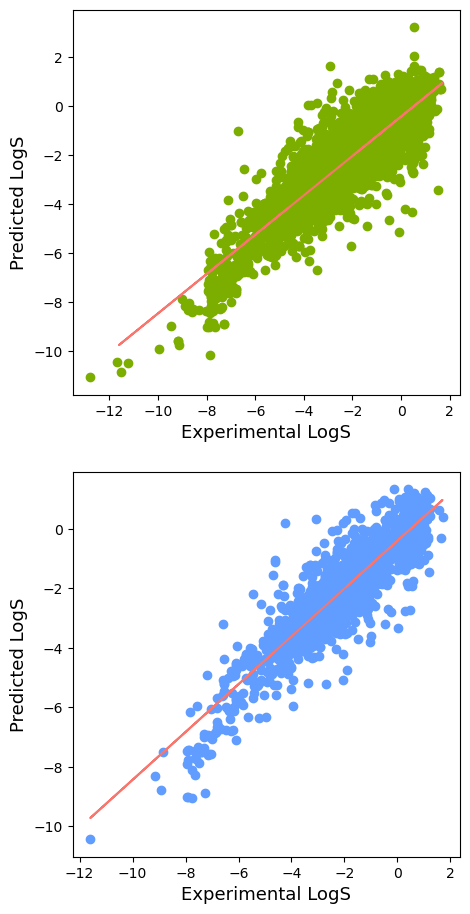

In [35]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_descriptor_MLR.png',dpi=300)
#plt.savefig('output/paper_logS_descriptor_MLR.pdf',dpi=300)

plt.show()

### 2-2.ランダムフォレスト回帰（RFR）

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
%%time
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

CPU times: total: 43.5 s
Wall time: 48.9 s


RandomForestRegressor(random_state=42)

【解説】scikit-learnの`RandomForestRegressor`  

ランダムフォレスト（Random Forest）アルゴリズムを使用した回帰モデルを実装するためのクラスです。ランダムフォレストは、多くの決定木（Decision Trees）を組み合わせて、回帰タスクや分類タスクなどさまざまな機械学習タスクに対処する強力なアンサンブル学習アルゴリズムです。

以下は、`RandomForestRegressor`の基本的な使い方です：

1. `RandomForestRegressor`をインポートします。

```python
from sklearn.ensemble import RandomForestRegressor
```

2. `RandomForestRegressor`オブジェクトを作成します。必要なパラメータを指定することができますが、デフォルト値でも動作します。

```python
model = RandomForestRegressor(n_estimators=100, random_state=0)
```

- `n_estimators`: ランダムフォレスト内の決定木の数を指定します。一般的に、多くの木を使用するとモデルの性能が向上しますが、計算コストも増加します。
- `random_state`: ランダムな要素を制御するためのシード値を指定します。同じシード値を使用すると、再現可能な結果を得ることができます。

3. モデルを訓練データに適合させます。訓練データには説明変数（特徴量）と連続値の応答変数が含まれています。

```python
model.fit(X_train, y_train)
```

4. モデルが訓練データに適合したら、訓練データに対する予測を行うことができます。

```python
y_pred = model.predict(X_train)
```

5. モデルの性能を評価したり、新しいデータポイントに対する予測を行ったりする際に、モデルの機能や特性にアクセスできます。たとえば、各特徴量の重要度を評価するために`feature_importances_`属性を使用できます。

```python
feature_importance = model.feature_importances_
```

ランダムフォレストは、過剰適合（Overfitting）に強く、多くのハイパーパラメータ調整が不要な優れたモデルです。多くの決定木を組み合わせるため、個々の決定木の過剰適合が相殺され、安定した予測性能を提供します。また、ランダムフォレストは特徴量の重要度の推定や外れ値の処理にも役立ちます。

### R2スコア

In [38]:
Y_pred_train = model.predict(X_train)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 0.25
Coefficient of determination (R^2): 0.98


In [39]:
Y_pred_test = model.predict(X_test)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.64
Coefficient of determination (R^2): 0.88


### MAE

In [40]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.2f}'.format(mae))

Training MAE : 0.17


In [41]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.2f}'.format(mae))

Test MAE : 0.42


### RMSE

In [42]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.2f}'.format(rmse))

Training RMSE : 0.25


In [43]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.2f}'.format(rmse))

Test RMSE : 0.64


### Exp-Predict Plot

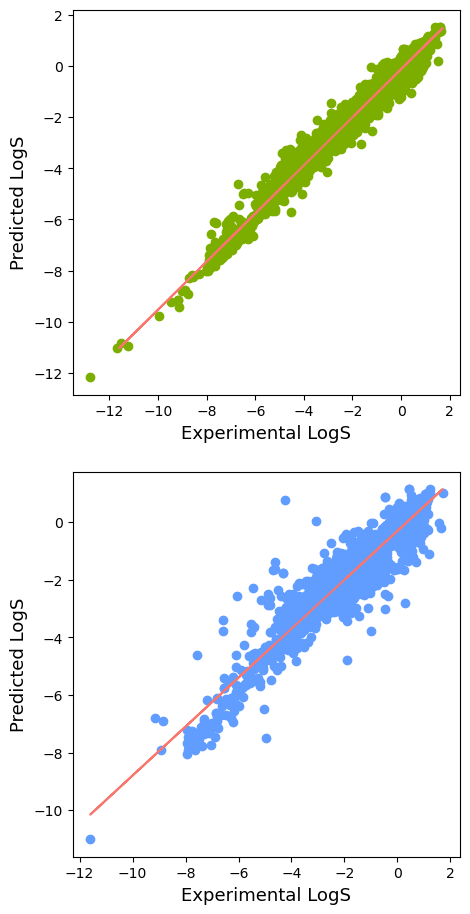

In [44]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_descriptor_RF.png',dpi=300)
#plt.savefig('output/paper_logS_descriptor_RF.pdf',dpi=300)

plt.show()

### 3. SHAP計算

「SHAP（SHapley Additive exPlanations）」は、特徴量の寄与度を計算するための統計的手法であり、機械学習モデルの予測を解釈するために使用されます。SHAP値は、特徴量ごとに予測に対する貢献度を示すため、モデルの予測がどの特徴量によって説明されているかを理解するのに役立ちます。

【参考】Mordredの記述子の種類  
https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [45]:
import shap

In [46]:
%%time
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

CPU times: total: 8min 12s
Wall time: 9min 53s


【解説】SHAP値を計算するためのライブラリとして「SHAP」があり、ケモインフォマテックス（Chemoinformatics）の分野でも利用されます。

SHAP計算の基本的な手順は以下の通りです：

1. 必要なライブラリをインポートします。

```python
import shap
```

2. SHAP値を計算したいモデルとデータを準備します。データは特徴量（特性）とその対応するターゲット（予測対象）を含む必要があります。モデルは、対象となる予測モデルです。

```python
# モデルを訓練済みモデルに置き換える
model = trained_model
data = X_test  # テストデータ
```

3. SHAP Explainerを作成します。SHAPライブラリでは、さまざまなモデルに対応するExplainerが提供されています。例えば、ツリーベースのモデルには`TreeExplainer`を、線形モデルには`LinearExplainer`を使用できます。

```python
explainer = shap.Explainer(model, data)
```

4. `shap_values`メソッドを使用してSHAP値を計算します。このメソッドは、各特徴量ごとに各データポイントに対するSHAP値を計算します。

```python
shap_values = explainer.shap_values(data)
```

5. SHAP値の可視化や解釈を行います。SHAP値を可視化することで、各特徴量が予測にどの程度影響を与えているかを理解できます。SHAP値のプロットや要約統計を生成して、モデルの予測を説明するのに役立ちます。

```python
shap.summary_plot(shap_values, data, feature_names=feature_names)
```

### Global bar plot

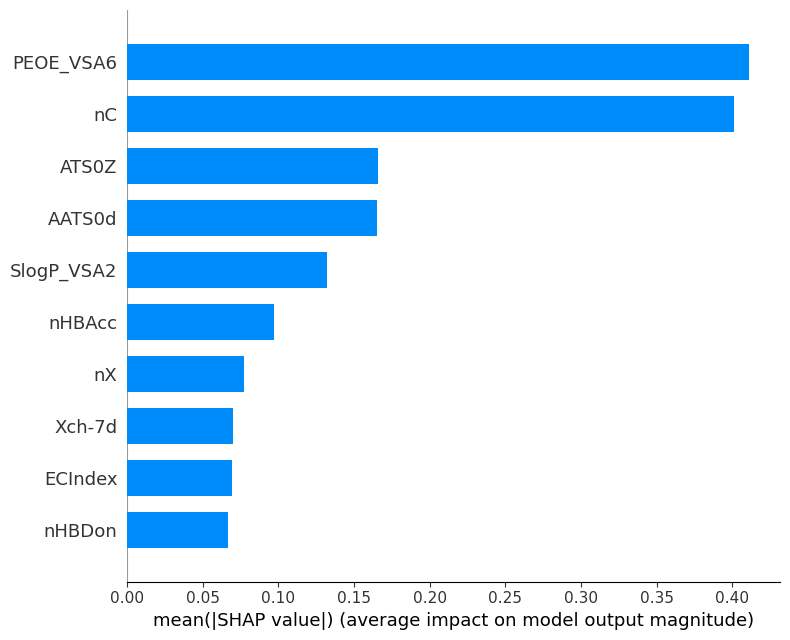

In [47]:
shap.summary_plot(shap_values, 
                  X_test, 
                  plot_type="bar",
                  show=False,
                  max_display=10,
                  plot_size=0.5
                 )

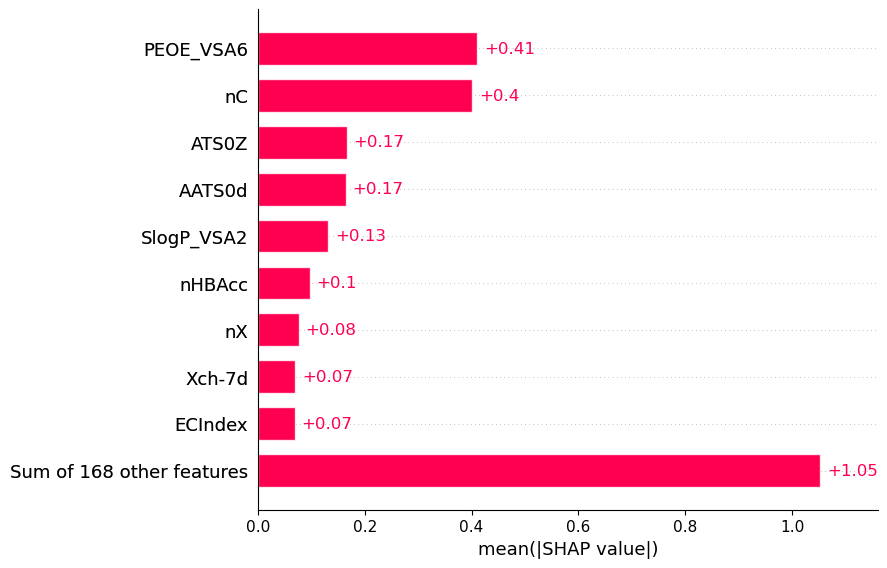

In [48]:
shap.plots.bar(shap_values, 
               max_display=10,
               show=False
              )

### beeswarm plot

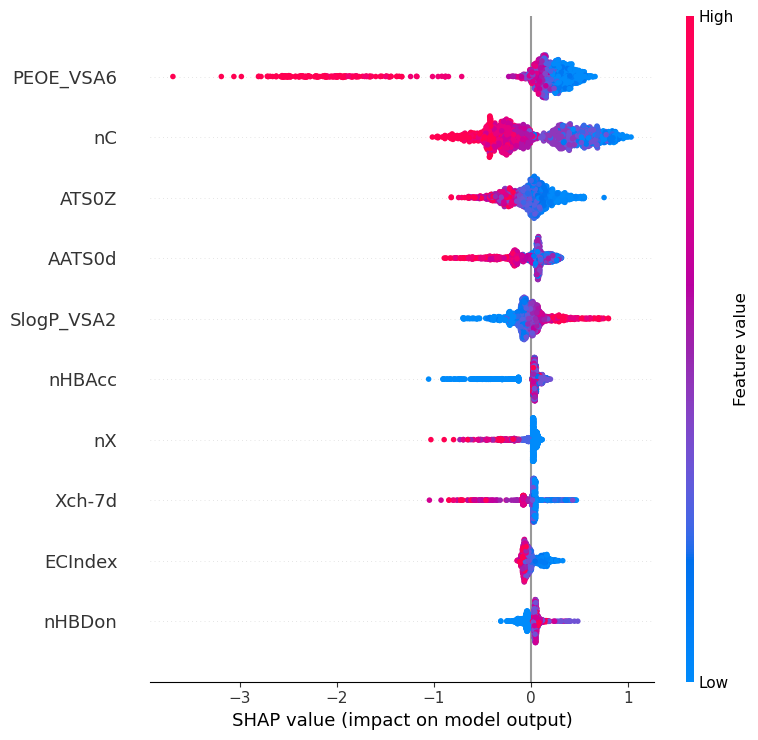

In [49]:
shap.summary_plot(shap_values, plot_type="dot", 
                  plot_size=0.6, 
                  show=False,
                  max_display=10
                 )

### waterfall plot

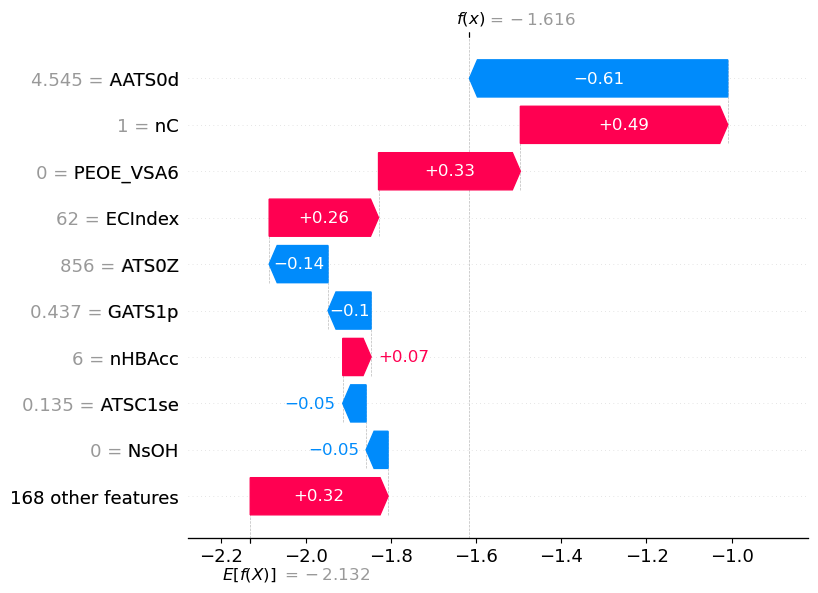

In [50]:
shap.plots.waterfall(shap_values[0]) 

### 4.ブラインドテスト
Additional Fileとして提供されているtestexperiment2upload2raw.csvでの事例です。All_Mordred_descriptors()のユーザー関数よりMordred記述子を得た後に、177記述子への枝狩りを行ったあとにRFR予測器にかけて評価します。

### ブラインドテスト 1

In [51]:
#Blind test
testdata2 = pd.read_csv('data/testexperiment2upload2raw.csv')

In [52]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

In [53]:
mordred_descriptors2 = All_Mordred_descriptors(testdata2['SMILES'])

100%|██████████| 32/32 [00:01<00:00, 16.64it/s]


In [54]:
# 166項目のカラムリスト
gf = X.columns.to_list()

In [55]:
# 166項目への絞り込み
Xnew2 = mordred_descriptors2[list(gf)]
Xnew2.shape

(32, 177)

In [56]:
# 予測値の出力
ynew2 = model.predict(Xnew2)
ynew2

array([-2.17447525, -2.22418333, -3.84014041, -2.3540325 , -4.32403677,
       -1.01796854, -3.37227463, -3.14304571, -2.93276633, -3.10912389,
       -2.553987  , -0.91064763, -1.91002813, -3.70986345, -2.63105667,
       -2.72254103, -3.13534332, -3.42725333, -2.51407693, -2.98125443,
       -4.73963332, -3.49576667, -0.91064763, -2.48300584, -3.75550833,
       -1.41245   , -2.74555148, -2.78686622, -4.60030964, -2.92443431,
       -3.31002833, -2.83545013])

### 記述子の出力保存

In [57]:
Xnew2.to_excel('output/file name descriptor 32data_descripter.xlsx', index = False)

### ブラインドテスト 2
Additional Fileとして、もう一つ提供されているtestexperiment2upload3raw.csvでの事例です。コードパターンには変更はありません。

In [58]:
#Solubility Challenge
testdata3 = pd.read_csv('data/testexperiment2upload3raw.csv')

In [59]:
mordred_descriptors3 = All_Mordred_descriptors(testdata3['SMILES'])

100%|██████████| 32/32 [00:01<00:00, 19.04it/s]


In [60]:
Xnew3 = mordred_descriptors3[list(gf)]
Xnew3.shape

(32, 177)

In [61]:
ynew3 = model.predict(Xnew3)
ynew3

array([-2.7084013 , -3.3615772 , -2.482405  , -2.32741771, -2.656961  ,
       -3.80376555, -4.033225  , -1.56235667, -1.97795   , -2.95533813,
       -1.49360145, -2.14385   , -2.55405349, -2.99938107, -2.7921742 ,
       -1.20149917, -2.87744583, -2.58238314, -2.33696041, -3.41099427,
       -2.09694501, -1.41869808, -2.77061587, -2.85602067, -1.8522239 ,
       -2.71902457, -1.38954634, -1.6935    , -1.35115913, -4.04070667,
       -2.37571357, -2.25385   ])

### 予測値の出力保存
上記のynew3の値をcsvで出力する方法として、numpyの`asarray()`メソッドでarray化したあとに`savetxt()`メソッドで出力する方法が紹介されています。csvでsaveする方法はpandasのdataframeからも行えるなど、幾つかの方法があります。

In [62]:
# define data
data = np.asarray(ynew3)

# save to csv file
np.savetxt('output/data_mordred.csv', data, delimiter=',')